In [223]:
%matplotlib inline
import matplotlib.image as mpimg
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

In [224]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Goodluck")

device = torch.device(device)

# Loading dataset

In [242]:
# Loading dataset
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(400, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


# Patching

In [243]:
patch_size = 400

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

img_patches.shape

(100, 400, 400, 3)

# Trying a simple FCN

In [244]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        # Input shape: (3, 100, 100)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),

        )

        self.unconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=10, padding=4),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=6, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.unconv(x)
        return x.squeeze()


In [245]:
summary(FCN(), input_size=(6, 3, 400, 400))

Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [6, 400, 400]             --
├─Sequential: 1-1                        [6, 32, 100, 100]         --
│    └─Conv2d: 2-1                       [6, 16, 400, 400]         448
│    └─MaxPool2d: 2-2                    [6, 16, 200, 200]         --
│    └─ReLU: 2-3                         [6, 16, 200, 200]         --
│    └─Conv2d: 2-4                       [6, 32, 200, 200]         12,832
│    └─MaxPool2d: 2-5                    [6, 32, 100, 100]         --
│    └─ReLU: 2-6                         [6, 32, 100, 100]         --
├─Sequential: 1-2                        [6, 1, 400, 400]          --
│    └─ConvTranspose2d: 2-7              [6, 16, 200, 200]         51,216
│    └─ReLU: 2-8                         [6, 16, 200, 200]         --
│    └─ConvTranspose2d: 2-9              [6, 1, 400, 400]          577
│    └─Sigmoid: 2-10                     [6, 1, 400, 400]          --
Total

In [246]:
n_img_patches = np.asarray(img_patches)
n_img_patches.shape

(100, 400, 400, 3)

In [247]:
# Util useless
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [262]:
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        output = output > 0.5
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append(output.eq(target).sum() / target.numel())

    return acc_history, loss_history

def get_mean_std(imgs):
    """
    Normalizes images with mean and standard deviation, by channel
    """
    mean = imgs.mean(axis=(0, 1, 2))
    std = imgs.std(axis=(0, 1, 2))
    
    return mean, std

def train(device):
    # creating the dataloader
    images = n_img_patches
    groundtruth = Tensor(gt_patches)

    mean, std = get_mean_std(images)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])
    ])
    
    images = torch.stack(([transform(img) for img in images]))
    
    pytorchDl = DataLoader(TensorDataset(images,groundtruth),batch_size = 32,shuffle=True)
    model = FCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.functional.binary_cross_entropy

    for i in range(100):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

    return transform, model
            

In [263]:
img_transform, model = train(device)

Epoch:  0  Accuracy:  tensor(0.1995, device='cuda:0')  Loss:  0.7147363424301147
Epoch:  1  Accuracy:  tensor(0.5444, device='cuda:0')  Loss:  0.5959005057811737
Epoch:  2  Accuracy:  tensor(0.7168, device='cuda:0')  Loss:  0.5291388779878616
Epoch:  3  Accuracy:  tensor(0.7701, device='cuda:0')  Loss:  0.48122314363718033
Epoch:  4  Accuracy:  tensor(0.7758, device='cuda:0')  Loss:  0.45317286252975464
Epoch:  5  Accuracy:  tensor(0.7729, device='cuda:0')  Loss:  0.44418372958898544
Epoch:  6  Accuracy:  tensor(0.7698, device='cuda:0')  Loss:  0.44946496188640594
Epoch:  7  Accuracy:  tensor(0.7877, device='cuda:0')  Loss:  0.4322262853384018
Epoch:  8  Accuracy:  tensor(0.7860, device='cuda:0')  Loss:  0.4205314889550209
Epoch:  9  Accuracy:  tensor(0.7679, device='cuda:0')  Loss:  0.4537961632013321
Epoch:  10  Accuracy:  tensor(0.7653, device='cuda:0')  Loss:  0.44346608221530914
Epoch:  11  Accuracy:  tensor(0.7723, device='cuda:0')  Loss:  0.4306095987558365
Epoch:  12  Accuracy:

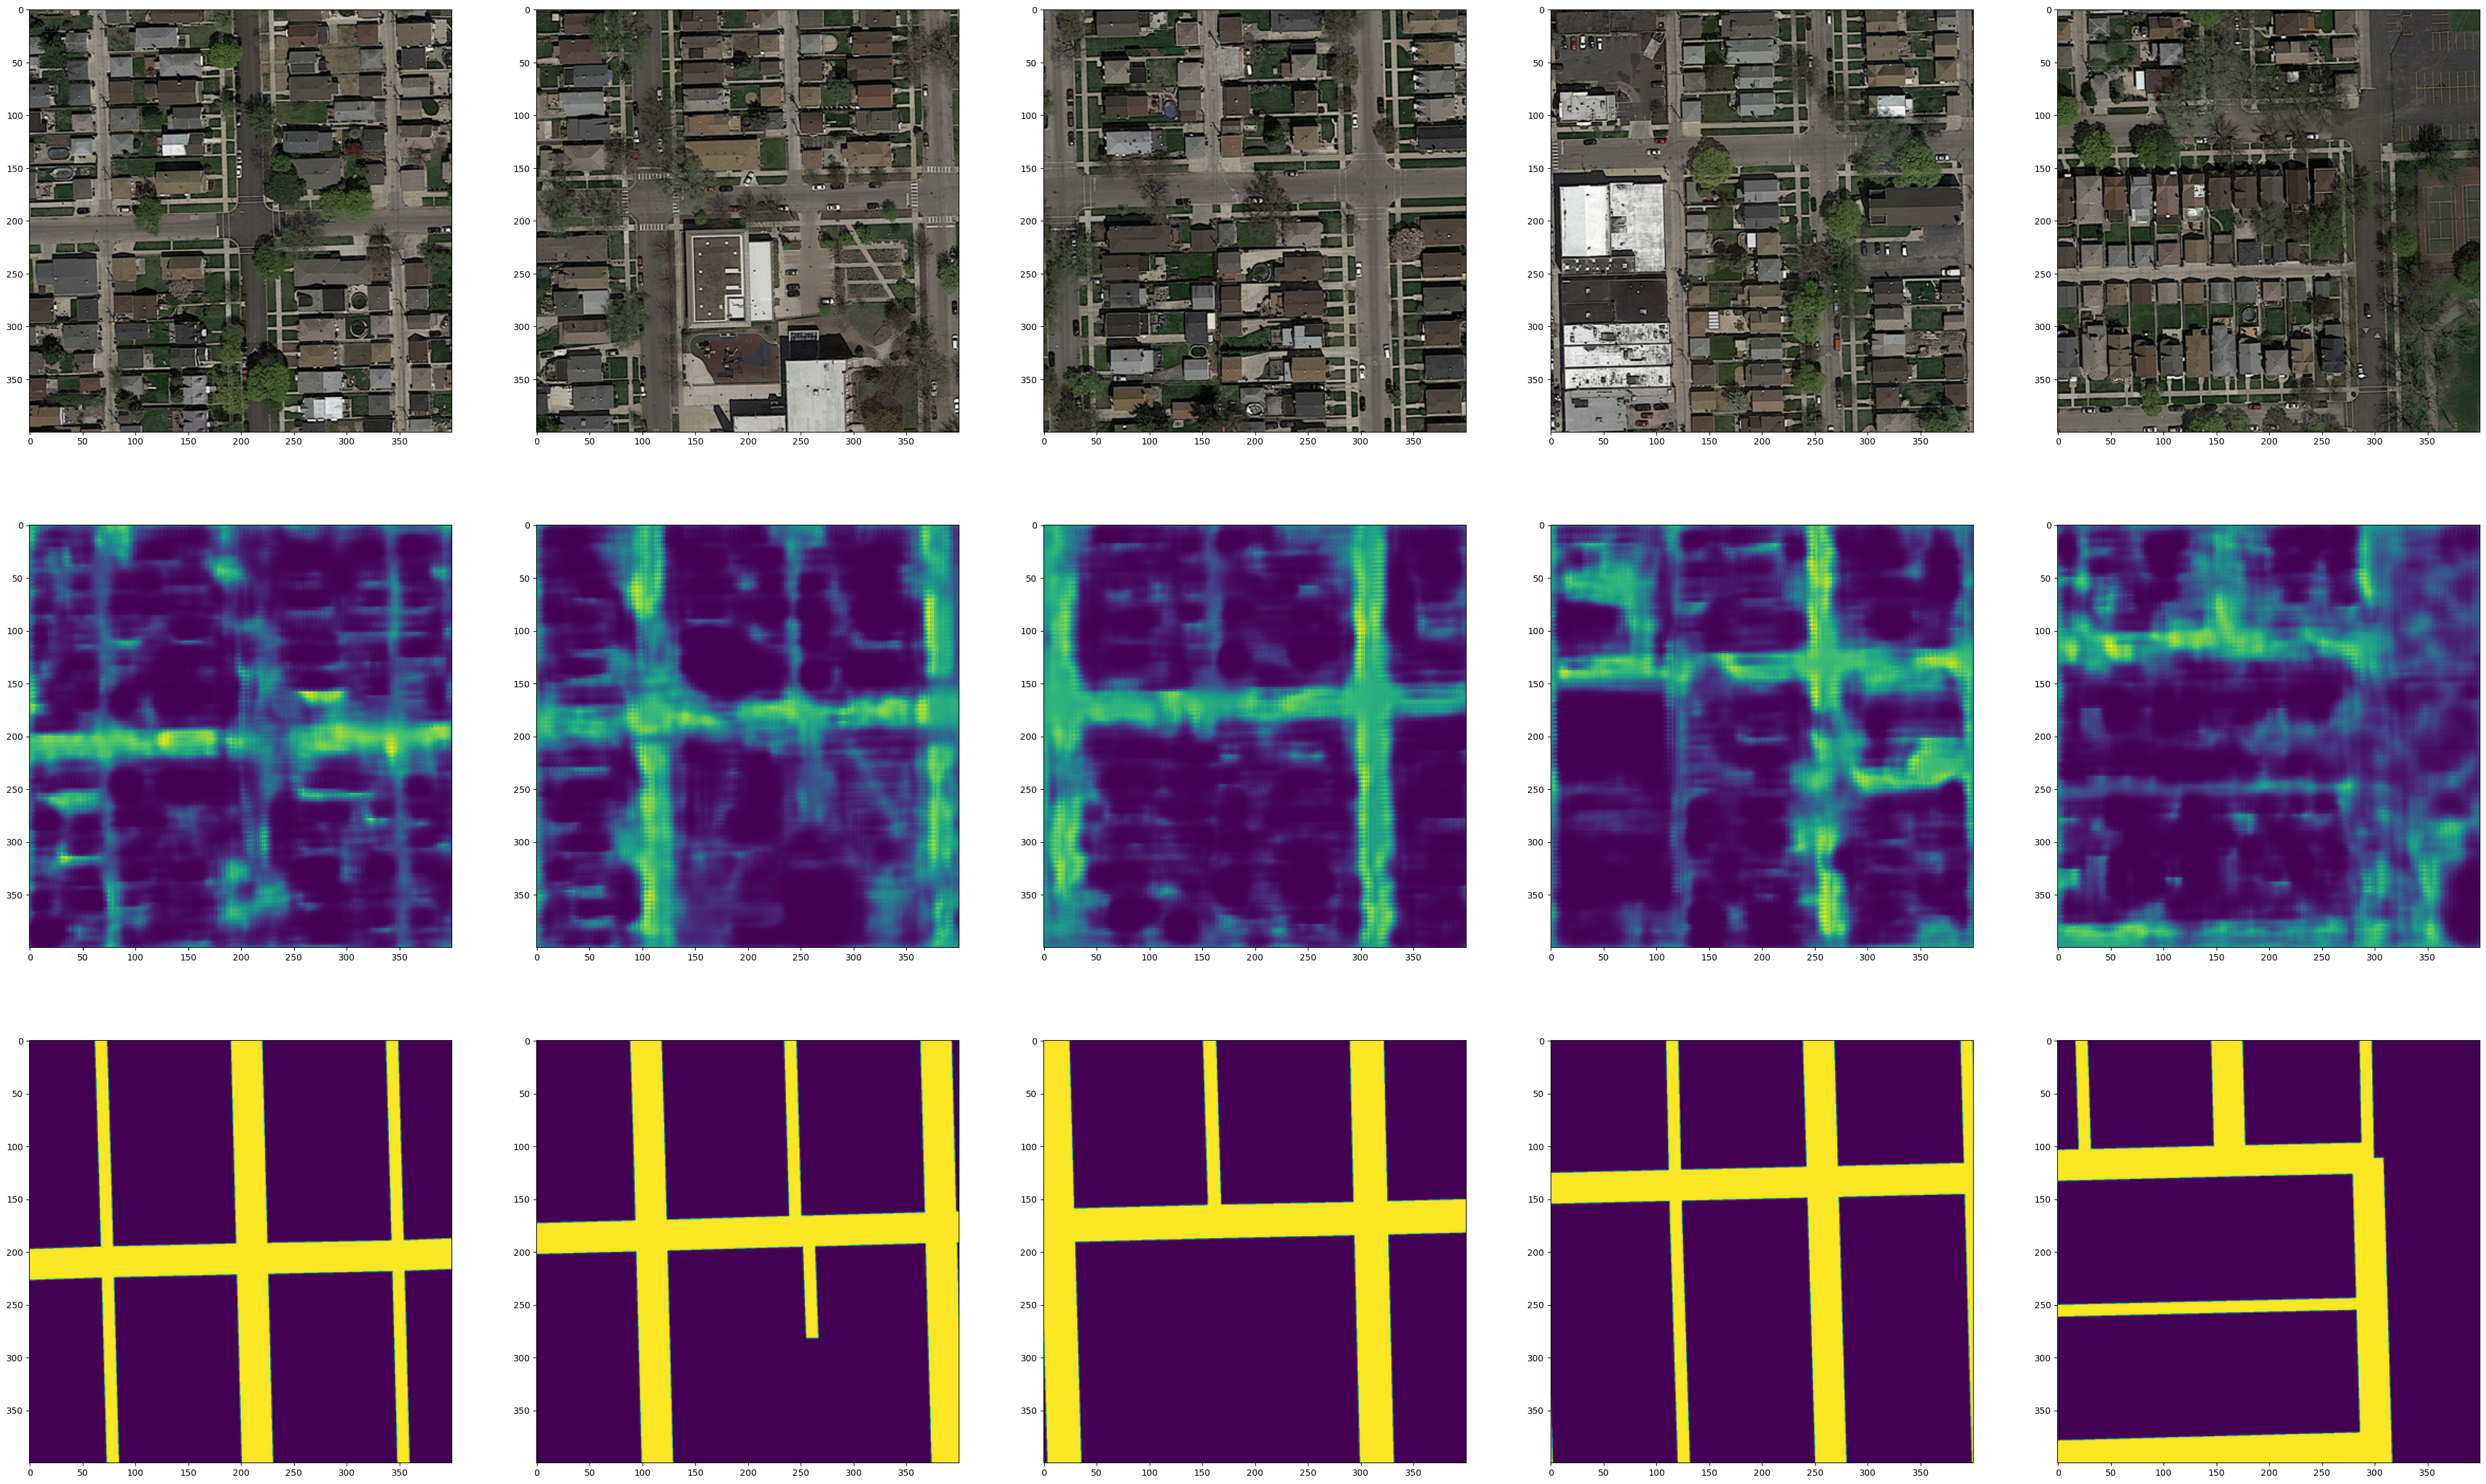

In [267]:
def visualize(model):
    model.eval()
    fig = plt.figure(figsize=(50, 30))
    with torch.no_grad():
        for i in range(5):
            img = imgs[i]
            gt_img = gt_imgs[i]
            img_patches = img_crop(img, patch_size, patch_size)
            gt_patches = img_crop(gt_img, patch_size, patch_size)
            inpp = img_patches[0]
            input_ = img_transform(inpp).to(device)
            output = model(input_).cpu().numpy().reshape((400, 400))
            input_ = input_.cpu().numpy()
            
            # from output generate
            fig.add_subplot(3, 5, 1+i)
            plt.imshow(inpp)
            fig.add_subplot(3, 5, 6+i)
            plt.imshow(output)
            fig.add_subplot(3, 5, 11+i)
            plt.imshow(gt_patches[0])
    plt.show()


visualize(model)